In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import skfda
from skfda.representation.interpolation import SplineInterpolation
from skfda.exploratory.visualization import Boxplot
import datetime as dt

In [18]:
# Variabili globali

path = 'pala_ok/acquisizione 22-05-2023/'

In [19]:
allacqui_temp = []

allacqui_input = []

# Andiamo a prendere tutti i path dei vari file

path_acquisizioni = [f for f in listdir(path) if isfile(join(path, f))]


In [20]:
# Abbiamo usato il range siccome i csv hanno separatori diversi

for a,b in zip(path_acquisizioni,range(0,len(path_acquisizioni))):
    if("input" in a):
        allacqui_input.append(pd.read_csv(path+a,sep='\t'))
    else:
        allacqui_temp.append(pd.read_csv(path+a,sep='\t'))

allacqui = []
for a,b in zip(allacqui_temp,range(len(allacqui_temp))):
    if(b % 3 ==0):
        allacqui.append([])
    allacqui[-1].append(a)




In [21]:
print(len(allacqui_input))
print(len(allacqui))
print(len(allacqui[0]))
#print(allacqui)

4
4
3


In [22]:
# Check delle dimensioni

print(type(allacqui[0][0][:10].mean()))

for a in range(len(allacqui[0])):
    print(allacqui[0][a].shape)

<class 'pandas.core.series.Series'>
(30192, 2)
(29638, 2)
(29639, 2)


In [23]:
media_mobile_ni = pd.DataFrame(columns=[])

for b in range(0,allacqui[0][0].shape[0],1):
    media_mobile_ni = pd.concat([media_mobile_ni,pd.DataFrame(allacqui[0][0][b:10+b].mean()).transpose()],ignore_index=True)

In [24]:
print(type(allacqui[0][0]))
print(allacqui[0][0].head(10))

<class 'pandas.core.frame.DataFrame'>
               time    Voltage
0  1684770601093366   9.999243
1  1684770601104366   9.998596
2  1684770601109366   9.996012
3  1684770601115386   9.996981
4  1684770601120370   9.997304
5  1684770601124370   9.998920
6  1684770601130366  10.000212
7  1684770601135370   9.998920
8  1684770601139367   9.998596
9  1684770601144369   9.998920


<Axes: >

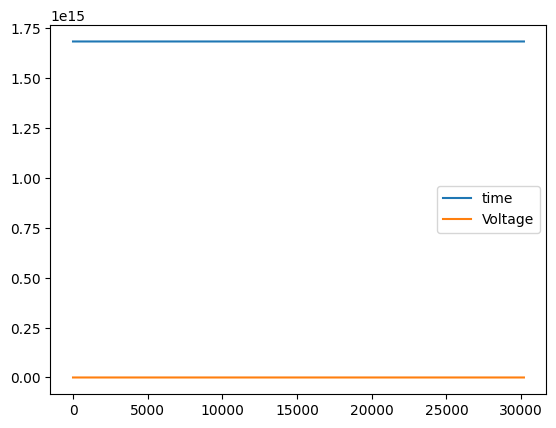

In [25]:
allacqui[0][0].plot()

In [28]:
# Andiamo a lavorare sui dati di national instrument, ne riduciamo le dimensioni usando la media

data_matrix = allacqui[0][2]['volts']
grid_points = allacqui[0][2]['time']

fd_manu = skfda.FDataGrid(
    data_matrix=data_matrix,
    grid_points=grid_points,
    dataset_name="Datagrid di esempio",
    argument_names=('time',),
    coordinate_names=('values',),
    interpolation=SplineInterpolation(interpolation_order=3)
)

c:\Users\pc\anaconda3\envs\manutenzione\lib\site-packages\skfda\exploratory\depth\multivariate.py:276: RuntimeWarning: invalid value encountered in divide
  return (  # type: ignore[no-any-return]


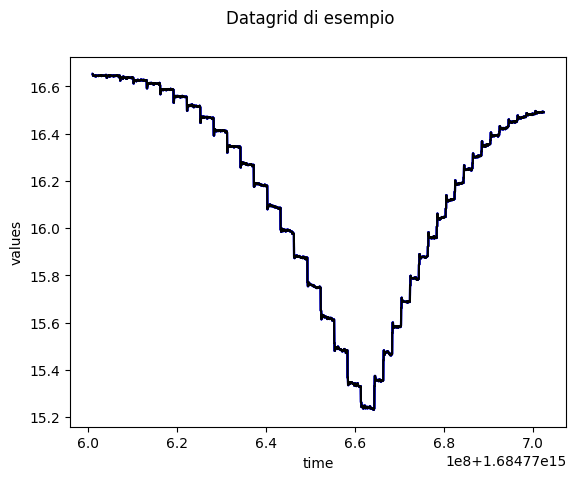

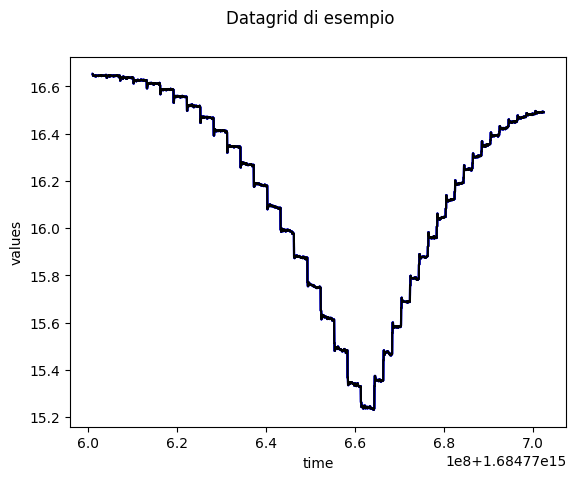

In [29]:
fdBoxplot = Boxplot(fd_manu)
fdBoxplot.show_full_outliers = True
fdBoxplot.plot()

In [30]:
import numpy as np
def makepwm(d):
    off_setList = len([d-x for x in b['time'] if (d - x > 0)])
    if(off_setList == 0):
       return 0
    else:
      return off_setList-1
makepwmElem = np.vectorize(makepwm)

In [31]:
all_PWMoutput = []

for acquisizione,b in zip(allacqui,allacqui_input): 
    
    all_PWMoutput.append([])
    for timestamp in acquisizione:
        all_PWMoutput[-1].append([])
        all_PWMoutput[-1][-1] = makepwmElem(timestamp['time'])


In [32]:
'''all_PWMoutput = []

for acquisizione,b in zip(allacqui,allacqui_input): 
    
    all_PWMoutput.append([])
    for timestamp in acquisizione:
        
        all_PWMoutput[-1].append([])
        for d in timestamp['time']:
            off_setList = len([
                d-x for x in b['time'] if (d - x > 0)
            ])
            if(off_setList == 0):
               all_PWMoutput[-1][-1].append(0)
            else:
                all_PWMoutput[-1][-1].append(b['pwm_percent'][off_setList-1])
'''
       



"all_PWMoutput = []\n\nfor acquisizione,b in zip(allacqui,allacqui_input): \n    \n    all_PWMoutput.append([])\n    for timestamp in acquisizione:\n        \n        all_PWMoutput[-1].append([])\n        for d in timestamp['time']:\n            off_setList = len([\n                d-x for x in b['time'] if (d - x > 0)\n            ])\n            if(off_setList == 0):\n               all_PWMoutput[-1][-1].append(0)\n            else:\n                all_PWMoutput[-1][-1].append(b['pwm_percent'][off_setList-1])\n"

In [33]:
print(len(all_PWMoutput))

print(all_PWMoutput[0][0][0])

4
0


In [34]:
# Andiamo a definire un datagrid per ogni dataframe

'''all_data_grid = []

for pwmoutput in all_PWMoutput:
    for a,b in zip(allacqui,path_acquisizioni):
    
        data_matrix = a[a.columns.values[1]]
        data_matrix_2 = pwmoutput
        grid_points = a[a.columns.values[0]]

        all_data_grid.append(skfda.FDataGrid(
        data_matrix=data_matrix,
        grid_points=grid_points,
        dataset_name=b,
        argument_names=(a.columns.values[0],),
        coordinate_names=(a.columns.values[1],),
        interpolation=SplineInterpolation(interpolation_order=1)
        ))'''
    

AttributeError: 'list' object has no attribute 'columns'

In [42]:
print(all_PWMoutput)
print(len(all_PWMoutput))
print(len(all_PWMoutput[0]))

for pwmoutput,acqui in zip(all_PWMoutput,allacqui):
    for a,b in zip(pwmoutput,acqui):

        print(len(a))
        print(type(a))
        print(len(b))
        print(type(b))
        print(' Questi sono i valori di a e b')

    

[[array([ 0,  0,  0, ..., 39, 39, 39]), array([ 0,  0,  0, ..., 39, 39, 39]), array([ 0,  0,  0, ..., 39, 39, 39])], [array([ 0,  0,  0, ..., 39, 39, 39]), array([ 0,  0,  0, ..., 39, 39, 39]), array([ 0,  0,  0, ..., 39, 39, 39])], [array([ 0,  0,  0, ..., 39, 39, 39]), array([ 0,  0,  0, ..., 39, 39, 39]), array([ 0,  0,  0, ..., 39, 39, 39])], [array([ 0,  0,  0, ..., 39, 39, 39]), array([ 0,  0,  0, ..., 39, 39, 39]), array([ 0,  0,  0, ..., 39, 39, 39])]]
4
3
30192
<class 'numpy.ndarray'>
30192
<class 'pandas.core.frame.DataFrame'>
 Questi sono i valori di a e b
29638
<class 'numpy.ndarray'>
29638
<class 'pandas.core.frame.DataFrame'>
 Questi sono i valori di a e b
29639
<class 'numpy.ndarray'>
29639
<class 'pandas.core.frame.DataFrame'>
 Questi sono i valori di a e b
29272
<class 'numpy.ndarray'>
29272
<class 'pandas.core.frame.DataFrame'>
 Questi sono i valori di a e b
29295
<class 'numpy.ndarray'>
29295
<class 'pandas.core.frame.DataFrame'>
 Questi sono i valori di a e b
29295


In [46]:
# Andiamo a definire un datagrid per ogni dataframe con NUOVE SPECIFICHE

all_data_grid = []

for pwmoutput,acqui in zip(all_PWMoutput,allacqui):
    for a,b in zip(acqui,pwmoutput):
    
        data_matrix = np.stack((np.array(a[a.columns.values[1]]), np.array(b)))
        grid_points = a[a.columns.values[0]]

        all_data_grid.append(skfda.FDataGrid(
        data_matrix=data_matrix,
        grid_points=grid_points,
        dataset_name='pippo',
        argument_names=(a.columns.values[0],),
        coordinate_names=(a.columns.values[1],),
        interpolation=SplineInterpolation(interpolation_order=1)
        ))
    

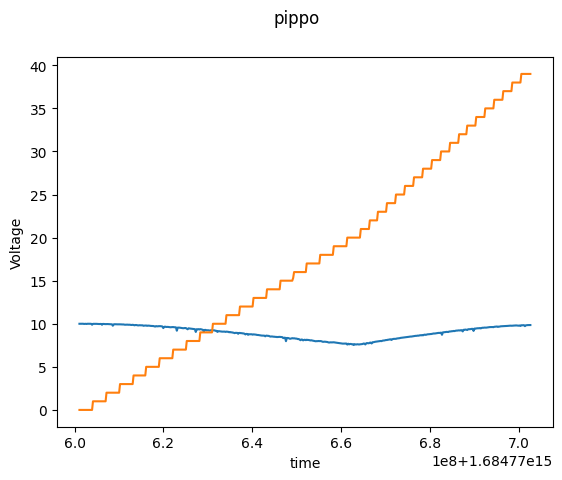

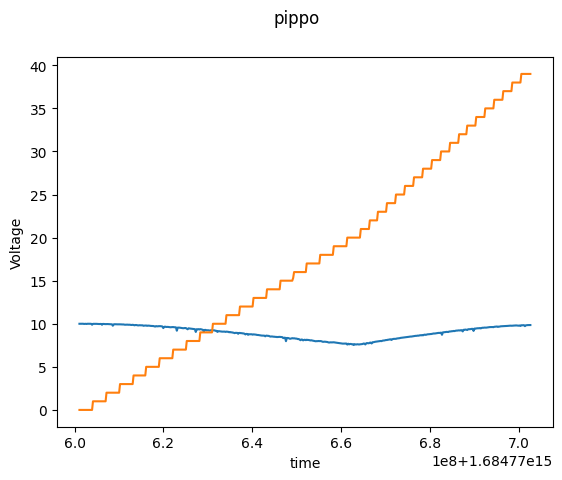

In [47]:
all_data_grid[0].plot()